In [1]:
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from torch.utils.data import DataLoader
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open('train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)

with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [5]:
N_COMPONENTS = 3
INPUT_STEP = 10
OUTPUT_STEP = 1
BATCH_SIZE = 8

## Create dataset

In [6]:
from torch.utils.data import Dataset

class HEDataset(Dataset):
    def __init__(self, data, pca=None, mean=None, std=None):
        print("Reduce dim")
        if not pca:
            pca = PCA(n_components=N_COMPONENTS)
            pca.fit(data)
            print(pca.explained_variance_)
        self.pca = pca
        transformed_data = pca.transform(data)
        timeframes = torch.Tensor(transformed_data)
        
        print("Data norm")
        if mean is None:
            mean = timeframes.mean(0)
        self.mean = mean
        print(self.mean)
        if std is None:
            std = timeframes.std(0)
        self.std = std
        transformed_data = timeframes - self.mean
        transformed_data = transformed_data / self.std
        self.original = transformed_data # todo debug only
        print("Unfold data into blocks")
        self.srcs = transformed_data[:-1].unfold(0, INPUT_STEP, 1).to(device)   # leave the last one for the last tgts
        self.tgts = torch.unsqueeze(transformed_data[INPUT_STEP:], 2).to(device)
        assert self.srcs.shape[0] == self.tgts.shape[0]
        step = self.srcs.shape[0] // 2
        assert torch.equal(self.srcs[step, :, -1].detach().unsqueeze(1), self.tgts[step-1, :, :].detach())
        print(self.srcs.shape, self.tgts.shape)

    def __getitem__(self, idx):
        src = self.srcs[idx, :, :]
        tgt = self.tgts[idx, :, :]
        return src, tgt
    
    def __len__(self):
        return self.srcs.shape[0]

In [7]:
# transformed_data = torch.Tensor(transformed_data).to(device)

In [8]:
# transformed_data.shape

In [9]:
# Training
# 1 2 3 -> 4
# 2 3 4 -> 5
# Testing
# 3 4 5 -> (6) todo mse of this step
# 4 5 (6) -> (7) todo mse of this step
# 5 (6) (7) -> (8) todo mse of this step
# todo 5 is seen, so performance may be benefited from this

In [10]:
train_data

array([[133.81 ,  88.55 ,  61.88 , ...,  44.483,  44.483,  44.483],
       [382.26 , 255.15 , 178.11 , ..., 127.37 , 127.37 , 127.37 ],
       [762.26 , 509.43 , 355.46 , ..., 252.56 , 252.56 , 252.56 ],
       ...,
       [296.03 , 197.63 , 138.   , ...,  98.799,  98.799,  98.799],
       [331.21 , 221.17 , 154.41 , ..., 110.47 , 110.47 , 110.47 ],
       [121.58 ,  80.613,  56.355, ...,  40.592,  40.592,  40.592]])

In [11]:
training_dataset = HEDataset(train_data[:5000])

Reduce dim
[1.10035800e+06 2.67009012e+00 1.49567762e+00]
Data norm
tensor([-2.1191e-05,  6.7003e-09, -1.8680e-08])
Unfold data into blocks
torch.Size([4990, 3, 10]) torch.Size([4990, 3, 1])


<AxesSubplot:ylabel='Count'>

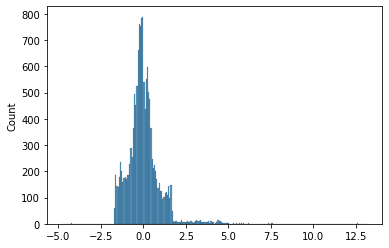

In [12]:
import seaborn as sns
_ = training_dataset.original.cpu().numpy()
sns.histplot(_.flatten())

In [13]:
validation_dataset = HEDataset(train_data[5000:7000], training_dataset.pca, training_dataset.mean, training_dataset.std)
# validation_dataset = HEDataset(val_data, training_dataset.pca, training_dataset.mean, training_dataset.std)

Reduce dim
Data norm
tensor([-2.1191e-05,  6.7003e-09, -1.8680e-08])
Unfold data into blocks
torch.Size([1990, 3, 10]) torch.Size([1990, 3, 1])


In [14]:
dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
dataloader_val = DataLoader(validation_dataset, batch_size=1, shuffle=False)

In [16]:
def train(model):
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-1)
    for epoch in range(7):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        for data in tqdm(dataloader, "Train"):
            optimizer.zero_grad()
            src, tgt = data 
            outputs, _ = model(src)
            l = loss(outputs, tgt)
            l.backward()
            optimizer.step()
            # print statistics
            running_loss += l
        print(f'[{epoch + 1}] loss: {running_loss/len(dataloader)}')
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for data in tqdm(dataloader_val, "Val"):
                src, tgt = data
                outputs, _ = model(src)
                l = loss(outputs, tgt)
                running_loss += l
            print(f'[{epoch + 1}] Val loss: {running_loss/len(dataloader_val)}') 
    return model  

### LSTM

In [17]:
lstm = nn.LSTM(INPUT_STEP, OUTPUT_STEP, 8, batch_first=True).to(device)
lstm = train(lstm)

Train:   0%|          | 0/624 [00:00<?, ?it/s]

[1] loss: 1.0014554262161255


Val:   0%|          | 0/1990 [00:00<?, ?it/s]

[1] Val loss: 1.372548222541809


Train:   0%|          | 0/624 [00:00<?, ?it/s]

[2] loss: 1.0000848770141602


Val:   0%|          | 0/1990 [00:00<?, ?it/s]

[2] Val loss: 1.3721033334732056


Train:   0%|          | 0/624 [00:00<?, ?it/s]

[3] loss: 1.000082015991211


Val:   0%|          | 0/1990 [00:00<?, ?it/s]

[3] Val loss: 1.3720958232879639


Train:   0%|          | 0/624 [00:00<?, ?it/s]

[4] loss: 1.0000816583633423


Val:   0%|          | 0/1990 [00:00<?, ?it/s]

[4] Val loss: 1.3720906972885132


Train:   0%|          | 0/624 [00:00<?, ?it/s]

[5] loss: 1.0000805854797363


Val:   0%|          | 0/1990 [00:00<?, ?it/s]

[5] Val loss: 1.3720892667770386


Train:   0%|          | 0/624 [00:00<?, ?it/s]

[6] loss: 1.0000810623168945


Val:   0%|          | 0/1990 [00:00<?, ?it/s]

[6] Val loss: 1.3720875978469849


Train:   0%|          | 0/624 [00:00<?, ?it/s]

[7] loss: 1.0000807046890259


Val:   0%|          | 0/1990 [00:00<?, ?it/s]

[7] Val loss: 1.3720874786376953


In [18]:
def predict_reconstruct_data(pca, mean, std, model, dataloader):
    outputs = []    
    model.eval()
    with torch.no_grad():
        for _, data in list(enumerate(tqdm(dataloader, "Predict"))):  # enumerate to reset the dataloader
            src, _ = data
            if type(model) == torch.nn.modules.rnn.LSTM:
                output, _ = model(src)                
            else:
                output = model(src)            
            outputs.append(output.reshape(N_COMPONENTS))
        # Unnormalized the data
        outputs = torch.stack(outputs, dim=0)
        outputs = outputs * std.to(device)
        outputs = outputs + mean.to(device)
        reconstructed_sklearn = pca.inverse_transform(outputs.cpu().numpy())
        return reconstructed_sklearn

In [19]:
reconstruct_lstm = predict_reconstruct_data(training_dataset.pca, training_dataset.mean, training_dataset.std, lstm, dataloader_val)

Predict:   0%|          | 0/1990 [00:00<?, ?it/s]

In [20]:
def evaluate_reconstructed(receive, expected):
    print(f"Receive shape: {receive.shape}. Expected shape: {expected.shape}")
    return mse(receive, expected)

In [21]:
mse(reconstruct_lstm, train_data[5000+INPUT_STEP:7000])

6323.864398371921

### Transformer

In [26]:
loss = nn.MSELoss()
#transformer_model = nn.Transformer(nhead=N_COMPONENTS, num_encoder_layers=32,   # d_model divisible by nhead
#                                   d_model=N_COMPONENTS, batch_first=True).to(device)
transformer_model = nn.Transformer(nhead=N_COMPONENTS, num_encoder_layers=32,   # d_model divisible by nhead
                                   d_model=N_COMPONENTS).to(device)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001)

In [27]:
def train_tf(model):
    model.train()
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-8)
    for epoch in range(3):  # loop over the dataset multiple times
        for i in tqdm(range(srcs.shape[1]//100)):
            optimizer.zero_grad()
            running_loss = 0.0

            src = srcs[:,i,:].T
            tgt = torch.unsqueeze(tgts[:,i], dim=0)
            outputs = model(src, tgt)
            l = loss(outputs, tgt)
            l.backward()
            optimizer.step()

            # print statistics
            running_loss += l
        print(f'[{epoch + 1}] loss: {running_loss / 2000:}')
    return model  

In [28]:
transformer_model = train_tf(transformer_model)

NameError: name 'srcs' is not defined

## Reconstruct 

In [ ]:
type(p_data)

In [ ]:
transformed_data.shape

In [ ]:
transformer_model.eval()
transformer_eval = transformed_data.copy()
for i in range(4, p_data.shape[1]-1):
    print(transformer_eval.shape)
    predict = transformer_model(torch.unsqueeze(torch.FloatTensor(transformer_eval[-2-INPUT_STEP:-2]), 0),  # INPUT_STEP steps before
                               torch.unsqueeze(torch.FloatTensor(transformer_eval[-1:]), 0))
    print(predict.shape)
    transformer_eval = np.append(transformer_eval, predict[0].detach().numpy(), axis=0)  # append prediction and 

In [ ]:
transformer_eval.shape

In [ ]:
reconstruct(transformer_eval)

todo

10s
10.1s
10.2s

a common algo to reduce dim, pca. 
- look at robustness for prediction further in time.
    - how to get more data simscale. Horizon 8 hours, train 6h, predict 2h. First step 10 mins
        - Increase data slowly, see the limit of ML methods
        - Tradition ML (lstm, transformers) will have problem. How long can we predict using this?
            - Change ML approach maybe to operator inference